In [1]:
import pandas as pd
import glob
import os
import csv
from datetime import datetime, timedelta
import json
from IPython.display import display, HTML

In [ ]:
df = pd.read_csv('test.csv', names=['datetime', 'power'], dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [2]:
power_logs = glob.glob("power/power_log*.csv")
power_logs

['power/power_log_2022-05-06.csv',
 'power/power_log_2022-06-09.csv',
 'power/power_log_2022-05-26.csv',
 'power/power_log_2022-05-05.csv',
 'power/power_log_2022-06-07.csv',
 'power/power_log_2022-05-23.csv',
 'power/power_log_2022-06-13.csv',
 'power/power_log_2022-06-01.csv',
 'power/power_log_2022-05-03.csv']

In [ ]:
power_logs_list = []

for power_log in power_logs:
    print(f"working on {power_log}")
    df = pd.read_csv(power_log, sep=',', names=['datetime', 'power'], dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
    power_logs_list.append(df)
    print(f"added {power_log}")

working on power/power_log_2022-05-06.csv
added power/power_log_2022-05-06.csv
working on power/power_log_2022-06-09.csv
added power/power_log_2022-06-09.csv
working on power/power_log_2022-05-26.csv
added power/power_log_2022-05-26.csv
working on power/power_log_2022-05-05.csv
added power/power_log_2022-05-05.csv
working on power/power_log_2022-06-07.csv
added power/power_log_2022-06-07.csv
working on power/power_log_2022-05-23.csv
added power/power_log_2022-05-23.csv
working on power/power_log_2022-06-13.csv
added power/power_log_2022-06-13.csv
working on power/power_log_2022-06-01.csv
added power/power_log_2022-06-01.csv
working on power/power_log_2022-05-03.csv


In [3]:
# df = pd.read_csv('power/power_log_2022-05-06.csv', names=['datetime', 'power'], dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df = pd.read_csv('power/power_log_2022-05-05.csv', names=['datetime', 'power'], dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [4]:
df

,power
datetime,
2022-02-14 15:05:56.374,115.90
2022-02-14 15:05:56.865,116.25
2022-02-14 15:05:57.344,116.15
2022-02-14 15:05:57.826,115.83
2022-02-14 15:05:58.305,115.25
...,...
2022-05-05 10:47:11.464,187.25
2022-05-05 10:47:12.333,187.25
2022-05-05 10:47:13.177,187.28


In [76]:
header_info = []
with open('power/09-37-42.CSV') as f:
    csv_reader = csv.reader(f)
    
    for i, row in enumerate(csv_reader):
        header_info.append(row)
        
        if i == 4: break

df = pd.read_csv('power/09-37-42.CSV', low_memory=False, skiprows=7, names=['power'], usecols=[1])

In [77]:
header_info

[['Tektronix PA1000'],
 ['Serial Number:', 'C040335'],
 ['Firmware Version:', '1.3.15'],
 ['Start Date (YYYYMMDD):', '2022-02-01'],
 ['Start Time (24hr):', '09:37:42']]

In [78]:
date = header_info[3][1]
time = header_info[4][1]
datetime_format = "%Y-%m-%d %H:%M:%S"

datetime_str = f"{date} {time}"

timedate = datetime.strptime(datetime_str, datetime_format)

print(timedate)
print(timedate + timedelta(0,1))
log_times = [timedate + timedelta(0, delta) for delta in range(df.size)]

2022-02-01 09:37:42
2022-02-01 09:37:43


In [79]:
df.insert(0, "datetime", log_times)

In [80]:
df.set_index('datetime', inplace=True)
print(df)

                      power
datetime                   
2022-02-01 09:37:42  117.40
2022-02-01 09:37:43  116.95
2022-02-01 09:37:44  116.23
2022-02-01 09:37:45  116.00
2022-02-01 09:37:46  116.50
...                     ...
2022-02-03 15:42:20  117.64
2022-02-03 15:42:21  116.97
2022-02-03 15:42:22  117.01
2022-02-03 15:42:23  117.56
2022-02-03 15:42:24  118.06

[194683 rows x 1 columns]


In [ ]:
194683

# Big file

In [140]:
df = pd.read_csv('grouped_unrounded.csv', dtype={'datetime': "string", "power": float}, low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])

In [141]:
df.set_index('datetime', inplace=True)
df

,power
datetime,
2022-02-14 15:05:56.374,115.90
2022-02-14 15:05:56.865,116.25
2022-02-14 15:05:57.344,116.10
2022-02-14 15:05:57.826,115.80
2022-02-14 15:05:58.305,115.25
...,...
2022-06-13 09:19:20.444,79.80
2022-06-13 09:19:20.936,81.25
2022-06-13 09:19:21.415,80.80


### Fixing power difference

In [142]:
power_diff = 9.162812939836797
start_increase = "2022-05-23 09:48:48"
end_increase = "2022-05-24 14:00:00"

increased_section = df[start_increase : end_increase]
increased_section = increased_section.apply(lambda x: x - power_diff)

df.update(increased_section)

<AxesSubplot:xlabel='datetime'>

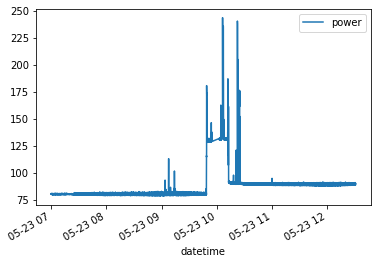

In [122]:
#Before
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

<AxesSubplot:xlabel='datetime'>

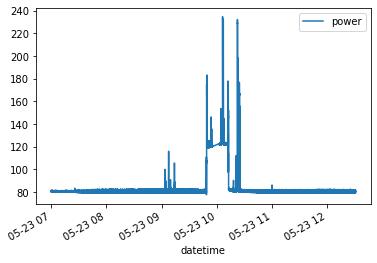

In [143]:
#After
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

In [144]:
df.to_csv("grouped_unrounded_adjusted.csv")

## Average power consumption

In [2]:
df_rounded = pd.read_csv('grouped_rounded_adjusted.csv', dtype={'datetime': "string", "power": float}, low_memory=False)
df_rounded['datetime'] = pd.to_datetime(df_rounded['datetime'])
df_rounded.set_index('datetime', inplace=True)
df_rounded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5900166 entries, 2022-02-14 15:05:56 to 2022-06-13 09:19:22
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 90.0 MB


In [3]:
df_unrounded = pd.read_csv('grouped_unrounded_adjusted.csv', dtype={'datetime': "string", "power": float}, low_memory=False)
df_unrounded['datetime'] = pd.to_datetime(df_unrounded['datetime'])
df_unrounded.set_index('datetime', inplace=True)
df_unrounded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11232088 entries, 2022-02-14 15:05:56.374000 to 2022-06-13 09:19:22.376000
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 171.4 MB


In [4]:
with open("power/db_vmaf_yuv_2022-06-07.json") as f:
    vmaf_data = json.load(f)

# print(json.dumps(vmaf_data["libvpx-vp9"]["1"], indent=2))

times = [[qp["start_time"], qp["end_time"]] for qp in vmaf_data["libvpx-vp9"]["1"]["evaluated_qps"]] + [[vmaf_data["libvpx-vp9"]["1"]["target_encode"]["start_time"], vmaf_data["libvpx-vp9"]["1"]["target_encode"]["end_time"]]]

In [5]:
vmaf_data.keys()

dict_keys(['libvpx-vp9', 'libx264', 'libx265', 'libsvtav1', 'VVC'])

In [6]:
vids_flat = {}

for codec in vmaf_data.keys():
    vids = vmaf_data[codec]
    
    for i, vid in enumerate(vmaf_data[codec].values()):
        if "error" in vid:
            continue
        vid["codec"] = codec
        vids_flat[f"{i}-{codec}"] = vid 

In [7]:
test_videos = {}

for codec in vmaf_data.keys():
    vids = {k: vmaf_data[codec][k] for k in ["66"]}
    
    for i, vid in enumerate(vids.values()):
        vid["codec"] = codec
        test_videos[f"{i}-{codec}"] = vid

In [284]:
animation_3_res = {k: vmaf_data["libvpx-vp9"][k] for k in ["1", "2", "3", "13", "14", "15"]}

In [317]:
animation_3_res["1"]["codec"] = "libvpx-vp9"

### Unrounded

In [8]:
def get_energy_video(df, times):
    avg_energy = [df[time[0] : time[1]].mean() for time in times]
    avg_energy = (sum(avg_energy) / len(avg_energy)).values[0]
    
    return avg_energy

def get_diff(val1, val2):
    return abs((val1 - val2) / ((val1 + val2) / 2) * 100)

In [9]:
get_video_time = lambda video: [[qp["start_time"], qp["end_time"]] for qp in video["evaluated_qps"]] + [[video["target_encode"]["start_time"], video["target_encode"]["end_time"]]]

video_times = [get_video_time(video) for video in vids_flat.values()]

In [10]:
avg_powers_unr = [get_energy_video(df_unrounded, time) for time in video_times]
# print(avg_powers_unr[0])

avg_powers_r   = [get_energy_video(df_rounded, time) for time in video_times]
# print(avg_powers_r[0])

percentage_diffs_power = [get_diff(unr, r) for unr, r in zip(avg_powers_unr, avg_powers_r)]
# print(percentage_diffs_power[0])

In [11]:
video_names = [video['video_name'] for video in vids_flat.values()]
res = [video['resolution'] for video in vids_flat.values()]
codec = [video['codec'] for video in vids_flat.values()]

d = {"codec": codec, "video_name": video_names, "resolution": res, "power_rounded": avg_powers_r, "power_unrounded": avg_powers_unr, "power difference": percentage_diffs_power}

powers_df = pd.DataFrame(data = d)

powers_df

,codec,video_name,resolution,power_rounded,power_unrounded,power difference
0,libvpx-vp9,Animation_1080P-05f8,360,115.512842,115.490600,0.019257
1,libvpx-vp9,Animation_1080P-05f8,720,129.244622,129.404393,0.123543
2,libvpx-vp9,Animation_1080P-05f8,1080,129.303035,129.233555,0.053749
3,libvpx-vp9,CoverSong_1080P-0188,360,117.313735,117.234878,0.067242
4,libvpx-vp9,HowTo_1080P-0267,360,115.776738,115.760609,0.013932
...,...,...,...,...,...,...
1908,VVC,LyricVideo_1080P-63d9,1080,161.693357,161.591969,0.062723
1909,VVC,NewsClip_1080P-4241,1080,165.116503,165.016349,0.060675
1910,VVC,TelevisionClip_1080P-5278,1080,162.405659,162.518631,0.069538
1911,VVC,Animation_1080P-4be3,1080,164.677370,164.625814,0.031312


In [12]:
# powers_df.sort_values(by="power_unrounded", ascending=False)
print("360p")
display(powers_df[powers_df["resolution"] == 360].groupby(["codec"]).mean().sort_values(by="power_unrounded", ascending=False))
print("720p")
display(powers_df[powers_df["resolution"] == 720].groupby(["codec"]).mean().sort_values(by="power_unrounded", ascending=False))
print("1080p")
display(powers_df[powers_df["resolution"] == 1080].groupby(["codec"]).mean().sort_values(by="power_unrounded", ascending=False))

360p


,resolution,power_rounded,power_unrounded,power difference
codec,,,,
libsvtav1,360.0,127.537203,127.552722,0.436742
libvpx-vp9,360.0,121.640899,121.635392,0.097548
libx264,360.0,120.502760,119.025760,1.391598
libx265,360.0,105.528071,105.631939,0.314572


720p


,resolution,power_rounded,power_unrounded,power difference
codec,,,,
libsvtav1,720.0,156.209828,156.190490,0.507978
libx264,720.0,152.027740,151.711483,2.206389
libx265,720.0,142.723011,142.764248,0.346092
libvpx-vp9,720.0,131.428195,131.435500,0.064186


1080p


,resolution,power_rounded,power_unrounded,power difference
codec,,,,
libsvtav1,1080.0,183.527223,183.623564,0.513918
libx265,1080.0,175.472595,175.400792,0.405759
libx264,1080.0,172.463846,171.909984,1.452387
VVC,1080.0,164.784577,164.771575,0.060312
libvpx-vp9,1080.0,131.687966,131.681424,0.033934


### Average power difference

In [13]:
powers_df["power difference"].mean()

0.6043111460959815

### Size Difference

In [15]:
rounded_mem = df_rounded.memory_usage(deep=True).sum()
unrounded_mem = df_unrounded.memory_usage(deep=True).sum()

print(f"Difference in memory usage: {(rounded_mem - unrounded_mem) / ((rounded_mem + unrounded_mem) / 2) * 100}")

rounded_file_size = 160007256
unrounded_file_size = 349845153

print(f"Difference in file size: {(rounded_file_size - unrounded_file_size) / ((rounded_file_size + unrounded_file_size) / 2) * 100}")

Difference in memory usage: -62.24425577626855
Difference in file size: -74.46778465648084


In [19]:
print(f"Unrounded file size is {unrounded_file_size/rounded_file_size}x larger")
print(f"Unrounded memory requirement is {unrounded_mem/rounded_mem}x more")

Unrounded file size is 2.186433051511114x larger
Unrounded memory requirement is 1.9036901673613928x more


# Filling Gaps

In [299]:
deltas = df.index.to_series().diff()
df.insert(1, "delta", deltas.dt.seconds)

In [300]:
newdf = df.query('delta == 2')

In [305]:
missing_times = newdf.index.to_frame().apply(lambda x: x - timedelta(0, 1))

missing_times = missing_times.assign(power = lambda x: (df.loc[x.index]['power'] + df.loc[x.index - timedelta(0, 2)]['power'].values) / 2)
missing_times.set_index('datetime', inplace=True)
missing_times

,power
datetime,
2022-02-14 15:06:19,115.312500
2022-02-14 15:09:14,114.421875
2022-02-14 15:16:12,115.296875
2022-02-14 15:20:09,211.250000
2022-02-14 15:24:00,170.843750
...,...
2022-06-13 09:12:32,80.390625
2022-06-13 09:12:35,79.875000
2022-06-13 09:13:29,81.078125


In [307]:
res = df.append(test, ignore_index=False)
res.sort_index(inplace=True)
res = res.drop(columns=["delta"])
res

,power
datetime,
2022-02-14 15:05:56,115.87500
2022-02-14 15:05:57,116.18750
2022-02-14 15:05:58,115.53125
2022-02-14 15:05:59,114.37500
2022-02-14 15:06:00,114.09375
...,...
2022-06-13 09:19:18,80.93750
2022-06-13 09:19:19,79.68750
2022-06-13 09:19:20,80.06250


In [308]:
res.iloc[[22,23,24,25,192,193]]

,power
datetime,
2022-02-14 15:06:18,114.437500
2022-02-14 15:06:19,115.312500
2022-02-14 15:06:20,116.187500
2022-02-14 15:06:21,115.125000
2022-02-14 15:09:12,115.020833
2022-02-14 15:09:13,113.906250


In [309]:
df.iloc[[22,23,24,25,192,193]]

,power,delta
datetime,,
2022-02-14 15:06:18,114.43750,1.0
2022-02-14 15:06:20,116.18750,2.0
2022-02-14 15:06:21,115.12500,1.0
2022-02-14 15:06:22,114.03125,1.0
2022-02-14 15:09:13,113.90625,1.0
2022-02-14 15:09:15,114.93750,2.0


In [311]:
deltas = res.index.to_series().diff()
res.insert(1, "delta", deltas.dt.seconds)

ValueError: cannot insert delta, already exists

In [315]:
test = res.query('delta == 2')
test

,power,delta
datetime,,


In [35]:
gaps = deltas[deltas > timedelta(0, 1)]
gaps

23        0 days 00:00:02
72        0 days 00:00:05
193       0 days 00:00:02
238       0 days 00:00:33
578       0 days 00:00:02
                ...      
5899760   0 days 00:00:02
5899762   0 days 00:00:02
5899815   0 days 00:00:02
5899816   0 days 00:00:02
5899931   0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [36]:
sorted_gaps = gaps.sort_values(ascending=False)

In [37]:
sorted_gaps

1686122   44 days 13:31:00
2890453    2 days 18:06:15
1686147    1 days 08:25:01
427950     1 days 01:07:40
2293730    0 days 05:44:16
                ...       
1921153    0 days 00:00:02
1920750    0 days 00:00:02
1920578    0 days 00:00:02
1920406    0 days 00:00:02
5899931    0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [ ]:
23750

In [42]:
deltas2 = df2['datetime'].diff()
gaps2 = deltas2[deltas2 > timedelta(0, 1)]
sorted_gaps2 = gaps2.sort_values(ascending=False)

In [43]:
sorted_gaps2

9558891    44 days 13:31:00
15704415    2 days 18:06:15
9559044     1 days 08:25:01
2436390     1 days 01:07:40
13003467    0 days 05:44:16
                 ...       
10889478    0 days 00:00:02
10887021    0 days 00:00:02
10885968    0 days 00:00:02
10884915    0 days 00:00:02
29123823    0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [47]:
sorted_gaps2[sorted_gaps2 < timedelta(0, 3)]

20048956   0 days 00:00:02
20048492   0 days 00:00:02
20093890   0 days 00:00:02
20103058   0 days 00:00:02
20134818   0 days 00:00:02
                 ...      
10889478   0 days 00:00:02
10887021   0 days 00:00:02
10885968   0 days 00:00:02
10884915   0 days 00:00:02
29123823   0 days 00:00:02
Name: datetime, Length: 23956, dtype: timedelta64[ns]

# Fixing 10 watt difference

In [125]:
# df = pd.read_csv('power/power_log_2022-05-26.csv', names=['datetime', 'power'], dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df = pd.read_csv('test10.csv', dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [126]:
df

,power
datetime,
2022-02-14 15:05:56,116.06
2022-02-14 15:05:57,116.00
2022-02-14 15:05:58,114.94
2022-02-14 15:05:59,114.10
2022-02-14 15:06:00,114.25
...,...
2022-06-13 09:19:18,79.70
2022-06-13 09:19:19,80.30
2022-06-13 09:19:20,80.50


<AxesSubplot:xlabel='datetime'>

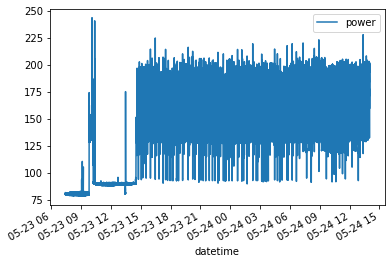

In [127]:
df['23-05-2022 07:25':'24-05-2022 14:00'].plot()

<AxesSubplot:xlabel='datetime'>

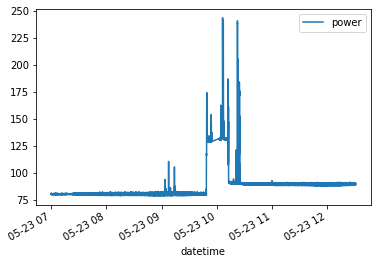

In [69]:
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

In [71]:
lower_power = df["23-05-2022 7:00" : "23-05-2022 9:00"]
higher_power = df["23-05-2022 10:30" : "23-05-2022 12:30"]

In [88]:
print(f"Lower avg: {lower_power.mean().values[0]}, higher avg: {higher_power.mean().values[0]}, diff: {higher_power.mean().values[0] - lower_power.mean().values[0]}")

Lower avg: 80.45737104135029, higher avg: 89.62018398118708, diff: 9.162812939836797


In [219]:
df.loc["23-05-2022 09:48"]

,power
datetime,
2022-05-23 09:48:00,79.900000
2022-05-23 09:48:01,79.800000
2022-05-23 09:48:02,80.500000
2022-05-23 09:48:03,81.300000
2022-05-23 09:48:04,81.100000
2022-05-23 09:48:05,80.750000
2022-05-23 09:48:06,79.750000
2022-05-23 09:48:07,80.250000
2022-05-23 09:48:08,81.000000


<AxesSubplot:xlabel='datetime'>

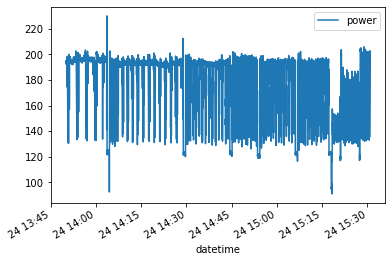

In [62]:
df['24-05-2022 13:50':'24-05-2022 15:30'].plot()

In [58]:
df.loc["24-05-2022 13:59"]

,power
datetime,
2022-05-24 13:59:00,195.9
2022-05-24 13:59:01,192.8
2022-05-24 13:59:02,189.1
2022-05-24 13:59:03,193.5
2022-05-24 13:59:04,184.0
2022-05-24 13:59:05,195.8
2022-05-24 13:59:06,194.6
2022-05-24 13:59:07,195.5
2022-05-24 13:59:08,197.0
